In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as ipyd
import scipy.misc
from libs import utils
import scipy.io

import warnings
warnings.filterwarnings('ignore')

In [3]:
from libs import vgg19

#start an interactive session
sess = tf.InteractiveSession()

images = tf.placeholder(tf.float32, [1, 224, 224, 3])
train_mode = tf.placeholder(tf.bool)

#load the model
vgg = vgg19.Vgg19()
vgg.build(images, train_mode)

sess.run(tf.global_variables_initializer())

In [4]:
g = tf.get_default_graph()
names = [op.name for op in g.get_operations()]
print('Sample of available operations: \n',names[:10])

Sample of available operations: 
 ['Placeholder', 'Placeholder_1', 'mul/y', 'mul', 'Const', 'split/split_dim', 'split', 'sub/y', 'sub', 'sub_1/y']


In [5]:
VGG_MEAN = [103.939, 116.779, 123.68]

VGG19_LAYERS = (
  'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

  'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

  'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
  'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

  'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
  'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

  'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
  'relu5_3', 'conv5_4', 'relu5_4'
)


def net_preloaded(input_image, pooling):
    data_dict = np.load('libs/vgg19.npy', encoding='latin1').item()
    net = {}
    current = input_image
    for i, name in enumerate(VGG19_LAYERS):
        kind = name[:4]
        if kind == 'conv':
            kernels = get_conv_filter(data_dict, name)
            # kernels = np.transpose(kernels, (1, 0, 2, 3))

            bias = get_bias(data_dict, name)
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]

            # bias = bias.reshape(-1)
            current = conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = pool_layer(current, pooling)

        net[name] = current

    assert len(net) == len(VGG19_LAYERS)
    return net

def conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, weights, strides=(1, 1, 1, 1), padding='SAME')
    return tf.nn.bias_add(conv, bias)


def pool_layer(input, pooling):
    if pooling == 'avg':
        return tf.nn.avg_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')
    else:
        return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')

# before we feed the image into the network, we preprocess it by 
# extracting the mean_pixel from it.
def preprocess(image):
    return image - VGG_MEAN

# remember to unprocess it before you plot it out and save it.
def unprocess(image):
    return image + VGG_MEAN

def get_conv_filter(data_dict, name):
    return tf.constant(data_dict[name][0], name="filter")

def get_bias(data_dict, name):
    return tf.constant(data_dict[name][1], name="biases")

In [6]:
from functools import reduce
from PIL import Image

# feel free to try different layers
CONTENT_LAYERS = ('relu4_2', 'relu5_2')
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

VGG_MEAN = [103.939, 116.779, 123.68]

def stylize(content, styles, network_path='libs/imagenet-vgg-verydeep-19.mat', 
            iterations=1000, content_weight=5e0, content_weight_blend=0.5, style_weight=5e2, 
            style_layer_weight_exp=1,style_blend_weights=None, tv_weight=100,
            learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
            print_iterations=100, checkpoint_iterations=100, checkpoint_path=None,
            output_path=None):

    shape = (1,) + content.shape                             #content image shape : (1,433,770,3)
    style_shapes = [(1,) + style.shape for style in styles]  #style image shape : (1,600,800,3)
    content_features = {}
    style_features = [{} for _ in styles]

    # scale the importance of each style layers according to their depth. 
    # (deeper layers are more important if style_layers_weights > 1 (default = 1))
    layer_weight = 1.0
    style_layers_weights = {}                                # weight for different network layers
    for style_layer in STYLE_LAYERS:                                    
        style_layers_weights[style_layer] = layer_weight       #'relu1_1','relu2_1',...,'relu5_1'
        layer_weight *= style_layer_weight_exp                 # 1.0

    # normalize style layer weights
    layer_weights_sum = 0
    for style_layer in STYLE_LAYERS:                         #'relu1_1',..., 'relu5_1'
        layer_weights_sum += style_layers_weights[style_layer] # 5.0
    for style_layer in STYLE_LAYERS:
        style_layers_weights[style_layer] /= layer_weights_sum

    # FEATURE MAPS FROM CONTENT IMAGE
    # compute the feature map of the content image by feeding it into the network
    #the output net contains the features of each content layer
    g = tf.Graph()
    with g.as_default(), tf.Session() as sess:
        image = tf.placeholder('float', shape=shape)

        net = net_preloaded(image, pooling)             # {'conv1_1':Tensor,relu1_1:Tensor...}
        content_pre = np.array([preprocess(content)])   # (1,433,770,3) subtract the mean pixel
        for layer in CONTENT_LAYERS:                    #'relu4_2', 'relu5_2'
            content_features[layer] = net[layer].eval(feed_dict={image: content_pre})  

    # FEATURE MAPS (GRAM MATRICES) FROM STYLE IMAGE
    # compute style features of the style image by feeding it into the network
    # and calculate the gram matrix
    for i in range(len(styles)):
        g = tf.Graph()
        with g.as_default(), tf.Session() as sess:
            image = tf.placeholder('float', shape=style_shapes[i])
            net = net_preloaded(image, pooling)                           
            style_pre = np.array([preprocess(styles[i])])
            for layer in STYLE_LAYERS:              #'relu1_1', 'relu2_1',..., 'relu5_1'
                features = net[layer].eval(feed_dict={image: style_pre})  # relu_1:(1,600,800,64)
                features = np.reshape(features, (-1, features.shape[3]))  # (480000, 64)
                gram = np.matmul(features.T, features) / features.size    # (64,64)
                style_features[i][layer] = gram

    # make stylized image using backpropogation
    with tf.Graph().as_default():

        # Generate a random image (the output image) with the same shape as the content image
        initial = tf.random_normal(shape) * 0.256  
        image = tf.Variable(initial)
        net = net_preloaded(image, pooling)


        # CONTENT LOSS
        # we can adjust the weight of each content layers
        # content_weight_blend is the ratio of two used content layers in this example
        content_layers_weights = {}
        content_layers_weights['relu4_2'] = content_weight_blend 
        content_layers_weights['relu5_2'] = 1.0 - content_weight_blend      

        content_loss = 0
        content_losses = []
        for content_layer in CONTENT_LAYERS:
          # Use MSE as content losses
          # content weight is the coefficient for content loss
            content_losses.append(content_layers_weights[content_layer] * content_weight * 
                  (2 * tf.nn.l2_loss(net[content_layer] - content_features[content_layer]) /
                  content_features[content_layer].size))
        content_loss += reduce(tf.add, content_losses)

        # STYLE LOSS
        # We can specify different weight for different style images
        # style_layers_weights => weight for different network layers
        # style_blend_weights => weight between different style images

        if style_blend_weights is None:
            style_blend_weights = [1.0/len(styles) for _ in styles]
        else:
            total_blend_weight = sum(style_blend_weights)
            # normalization
            style_blend_weights = [weight/total_blend_weight
                                 for weight in style_blend_weights]

        style_loss = 0
        # iterate to calculate style loss with multiple style images
        for i in range(len(styles)):
            style_losses = []
            for style_layer in STYLE_LAYERS:             # e.g. relu1_1
                layer = net[style_layer]                   # relu1_1 of output image:(1,433,770,64)
                _, height, width, number = map(lambda i: i.value, layer.get_shape())  
                size = height * width * number
                feats = tf.reshape(layer, (-1, number))    # (333410,64)

                # Gram matrix for the features in relu1_1 of the output image.
                gram = tf.matmul(tf.transpose(feats), feats) / size
                # Gram matrix for the features in relu1_1 of the style image
                style_gram = style_features[i][style_layer]   

                # Style loss is the MSE for the difference of the 2 Gram matrices
                style_losses.append(style_layers_weights[style_layer] * 2 * 
                                    tf.nn.l2_loss(gram - style_gram) / style_gram.size)
            style_loss += style_weight * style_blend_weights[i] * reduce(tf.add, style_losses)

        # TOTAL VARIATION LOSS  
        # Total variation denoising to do smoothing; cost to penalize neighboring pixel
        # not used by the original paper by Gatys et al
        # According to the paper Mahendran, Aravindh, and Andrea Vedaldi. "Understanding deep 
        # image representations by inverting them."
        # Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2015.
        tv_y_size = _tensor_size(image[:,1:,:,:])
        tv_x_size = _tensor_size(image[:,:,1:,:])
        tv_loss = tv_weight * 2 * (
          (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) /
              tv_y_size) +
          (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) /
              tv_x_size))

        #OVERALL LOSS
        loss = content_loss + style_loss + tv_loss

        train_step = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon).minimize(loss)

        def print_progress():
            print('     iteration: %d' % i)
            print('  content loss: %g' % content_loss.eval())
            print('    style loss: %g' % style_loss.eval())
            print('       tv loss: %g' % tv_loss.eval())
            print('    total loss: %g' % loss.eval())

        def imsave(path, img):
            img = np.clip(img, 0, 255).astype(np.uint8)
            Image.fromarray(img).save(path, quality=95)

        # TRAINING
        best_loss = float('inf')
        best = None

        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            if (print_iterations and print_iterations != 0):
                print_progress()

            for i in range(iterations):

                train_step.run()

                last_step = (i == iterations - 1)
                if last_step or (print_iterations and i % print_iterations == 0):
                    print_progress()

                # store output and checkpoint images
                if (checkpoint_iterations and i % checkpoint_iterations == 0) or last_step:
                    this_loss = loss.eval()
                    if this_loss < best_loss:
                        best_loss = this_loss
                        best = image.eval()

                    img_out = unprocess(best.reshape(shape[1:]))

                    output_file = None
                    if not last_step:
                        if checkpoint_path:
                            output_file = checkpoint_path % i
                    else:
                        output_file = output_path

                    if output_file:
                        imsave(output_file, img_out)

    print("finish stylizing.")


def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)

#### I chose poster of fantastic beast 2 as content_image, 'cause it's comming to theater on 11/15 !

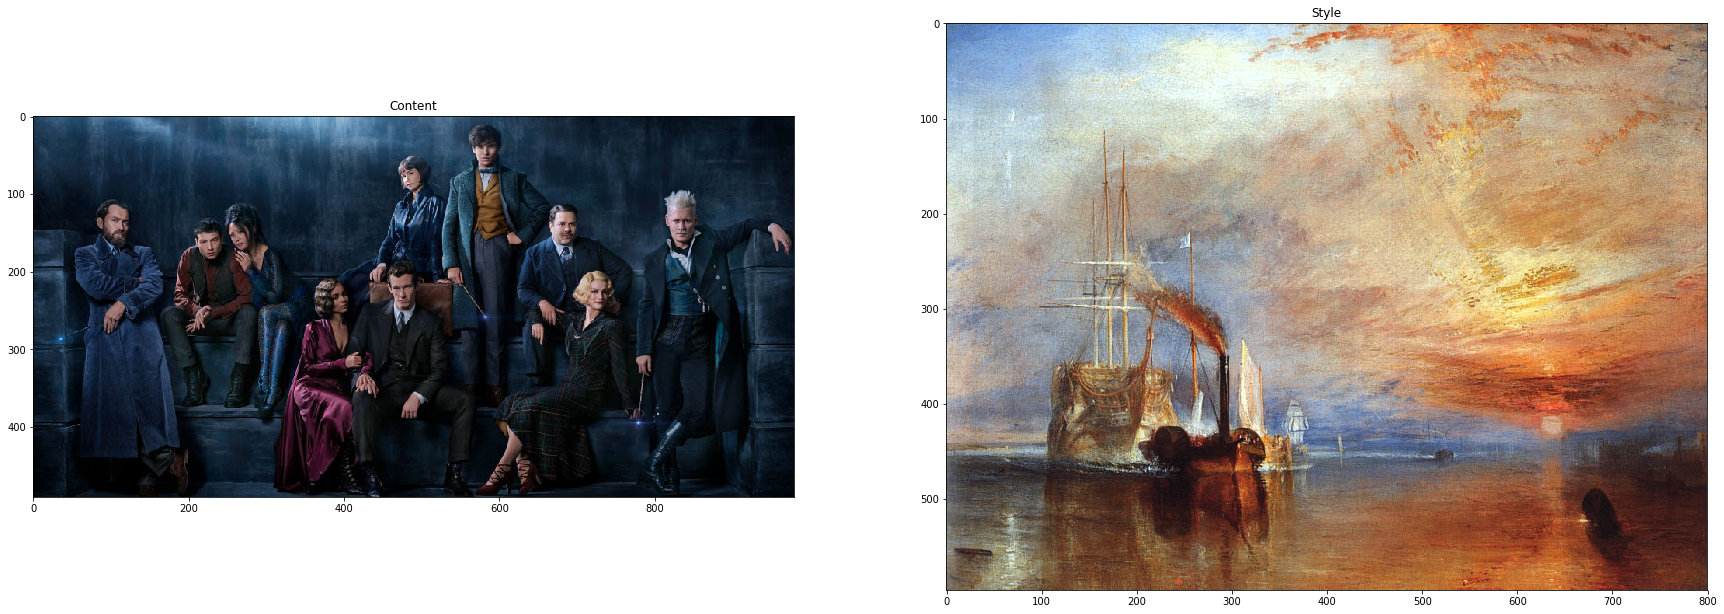

In [7]:
content_image = utils.loadImage('img/','fantastic-beast-2.jpg')
style_image = utils.loadImage('img/','Turner_temeraire_w.jpg')
utils.showImage(content_image, style_image)

## 1.Change the weights for the style, content, and denoising.

#### the original weights

In [26]:
checkpoint_path=None
output_path = 'img/' + 'turner-style-fantastic-beast-100.jpg'


stylize(content_image, [style_image], iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0
  content loss: 409090
    style loss: 1.95313e+06
       tv loss: 26.1433
    total loss: 2.36225e+06
     iteration: 0
  content loss: 397055
    style loss: 1.7587e+06
       tv loss: 16334.1
    total loss: 2.17209e+06
     iteration: 100
  content loss: 168201
    style loss: 47498.1
       tv loss: 17030.1
    total loss: 232729
     iteration: 200
  content loss: 155266
    style loss: 40446.7
       tv loss: 15675.2
    total loss: 211388
     iteration: 300
  content loss: 153916
    style loss: 33385.4
       tv loss: 15155.8
    total loss: 202457
     iteration: 400
  content loss: 157152
    style loss: 26865.8
       tv loss: 15256.5
    total loss: 199275
     iteration: 500
  content loss: 152874
    style loss: 27292.2
       tv loss: 14614
    total loss: 194781
     iteration: 600
  content loss: 150586
    style loss: 26177.5
       tv loss: 14110.2
    total loss: 190873
     iteration: 700
  content loss: 159802
    style loss: 38668
       tv lo

![title](img/turner-style-fantastic-beast-100.jpg)

From the result above, we can say that too much content has been overwritten by style information.<br>Therefore, I decided to tune up content_weight as well as tv_weight, and tune down style_weight, to see if we can get a better result.

In [ ]:
checkpoint_path=None
output_path = 'img/' + 'turner-style-fantastic-beast-100-6.jpg'
CONTENT_LAYERS = ('relu4_2', 'relu5_2')
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

stylize(content_image, [style_image], iterations=1000,
        content_weight=5e1, content_weight_blend=1, style_weight=5e1, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=130,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='max',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0
  content loss: 1.99404e+07
    style loss: 2.70728e+07
       tv loss: 34.0717
    total loss: 4.70133e+07
     iteration: 0
  content loss: 1.92162e+07
    style loss: 2.59409e+07
       tv loss: 28811.8
    total loss: 4.51859e+07
     iteration: 100
  content loss: 6.3851e+06
    style loss: 2.48633e+06
       tv loss: 221929
    total loss: 9.09337e+06
     iteration: 200
  content loss: 5.81618e+06
    style loss: 2.49177e+06
       tv loss: 192779
    total loss: 8.50073e+06
     iteration: 300
  content loss: 5.50965e+06
    style loss: 2.49875e+06
       tv loss: 181466
    total loss: 8.18986e+06
     iteration: 400
  content loss: 5.40492e+06
    style loss: 2.48913e+06
       tv loss: 175166
    total loss: 8.06922e+06
     iteration: 500
  content loss: 5.43468e+06
    style loss: 2.36357e+06
       tv loss: 170714
    total loss: 7.96896e+06
     iteration: 600
  content loss: 5.42566e+06
    style loss: 2.49498e+06
       tv loss: 167870
    total loss:

<img src="img/_turner-style-fantastic-beast-100-2.jpg">

Here we go, the result is very similar to orignal poster, but has overall brighter and lighter coloer, with more yellow and red.

This difference caused by the weight I changed. In funciton stylize(), total_loss is the sum of style layer * styler weight, content layer * content weight, and tv_loss. If I tune content weight up, in the model's point of view, it will be more worthy to decrease content layer loss, vise versa. Since the information of content and style is kinda contradict, I have much more content element in this result.
Moreover, I have tv_weight slightly tuned up, so the image become smoother than the previous one, and the faces are much clearer.


So far, I think that the combination of these two image haven't produce ideal result, therefore I'll user Rain Princess as style image for following test.
<img src="img/rain-princess.jpg">

In [17]:
checkpoint_path=None
style_image = utils.loadImage('img/','rain-princess.jpg')

output_path = 'img/' + 'turner-style-fantastic-beast-100-5.jpg'
CONTENT_LAYERS = ('relu4_2', 'relu5_2')
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

stylize(content_image, [style_image], iterations=1000,
        content_weight=2e1, content_weight_blend=1, style_weight=1e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=110,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='max',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0
  content loss: 7.97638e+06
    style loss: 5.41456e+07
       tv loss: 28.8044
    total loss: 6.2122e+07
     iteration: 0
  content loss: 7.68657e+06
    style loss: 5.18558e+07
       tv loss: 24507.2
    total loss: 5.95669e+07
     iteration: 100
  content loss: 4.48769e+06
    style loss: 907093
       tv loss: 176648
    total loss: 5.57143e+06
     iteration: 200
  content loss: 4.17881e+06
    style loss: 777308
       tv loss: 142348
    total loss: 5.09846e+06
     iteration: 300
  content loss: 3.79872e+06
    style loss: 1.21139e+06
       tv loss: 129184
    total loss: 5.1393e+06
     iteration: 400
  content loss: 3.88878e+06
    style loss: 745441
       tv loss: 125738
    total loss: 4.75996e+06
     iteration: 500
  content loss: 3.81552e+06
    style loss: 752037
       tv loss: 117959
    total loss: 4.68552e+06
     iteration: 600
  content loss: 3.79681e+06
    style loss: 787013
       tv loss: 117394
    total loss: 4.70121e+06
     iteratio

<img src="img/turner-style-fantastic-beast-100-5.jpg">

And this is the ouput of default layers and adjuested weight, we can use it to compare with following results

### 2.Use other layers in the model.
### You need to calculate both content loss and style loss from different layers in the model.

I found that all style_layers use first relu of each layer to compute loss, hence I would like to try last relu or pooling of each layers.

In [15]:
CONTENT_LAYERS = ('relu4_2', 'relu5_2')
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'pool3', 'pool4', 'relu5_4')

checkpoint_path=None

output_path = 'img/' + 'rain-fantastic-beast-1.jpg'

stylize(content_image, [style_image], iterations=1000,
        content_weight=1e1, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=110,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='max',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)


     iteration: 0
  content loss: 3.98797e+06
    style loss: 6.40368e+09
       tv loss: 28.8298
    total loss: 6.40767e+09
     iteration: 0
  content loss: 3.93374e+06
    style loss: 6.02133e+09
       tv loss: 23471.6
    total loss: 6.02529e+09
     iteration: 100
  content loss: 9.76644e+06
    style loss: 1.04912e+07
       tv loss: 320551
    total loss: 2.05782e+07
     iteration: 200
  content loss: 8.80272e+06
    style loss: 4.95792e+06
       tv loss: 296763
    total loss: 1.40574e+07
     iteration: 300
  content loss: 7.91272e+06
    style loss: 3.46404e+06
       tv loss: 282780
    total loss: 1.16595e+07
     iteration: 400
  content loss: 7.20269e+06
    style loss: 2.97165e+06
       tv loss: 271936
    total loss: 1.04463e+07
     iteration: 500
  content loss: 6.72795e+06
    style loss: 2.4662e+06
       tv loss: 263634
    total loss: 9.45778e+06
     iteration: 600
  content loss: 6.30679e+06
    style loss: 2.48636e+06
       tv loss: 255624
    total loss:

<img src='img/rain-fantastic-beast-1.jpg'>

And even moor poolings

In [16]:
CONTENT_LAYERS = ('relu4_2', 'relu5_2')
STYLE_LAYERS = ('pool1', 'pool2', 'pool3', 'pool4', 'relu5_4')

checkpoint_path=None
output_path = 'img/' + 'rain-fantastic-beast-2.jpg'

stylize(content_image, [style_image], iterations=1000,
        content_weight=1e1, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=110,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='max',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0
  content loss: 3.98816e+06
    style loss: 6.70994e+09
       tv loss: 28.791
    total loss: 6.71392e+09
     iteration: 0
  content loss: 3.93483e+06
    style loss: 6.29927e+09
       tv loss: 23403.7
    total loss: 6.30323e+09
     iteration: 100
  content loss: 9.55921e+06
    style loss: 2.68468e+07
       tv loss: 280929
    total loss: 3.66869e+07
     iteration: 200
  content loss: 8.52182e+06
    style loss: 7.90655e+06
       tv loss: 282542
    total loss: 1.67109e+07
     iteration: 300
  content loss: 7.68588e+06
    style loss: 7.59281e+06
       tv loss: 275889
    total loss: 1.55546e+07
     iteration: 400
  content loss: 6.93441e+06
    style loss: 4.51571e+06
       tv loss: 267752
    total loss: 1.17179e+07
     iteration: 500
  content loss: 6.57148e+06
    style loss: 4.84527e+06
       tv loss: 261335
    total loss: 1.16781e+07
     iteration: 600
  content loss: 7.63763e+06
    style loss: 5.0432e+06
       tv loss: 268974
    total loss: 

<img src='img/rain-fantastic-beast-2.jpg'>

It's very interesing that when I use more pooling, the stroke of output image become larger.
However, it's obvious that using pooling rather than relu is a bad idea, probably because pooling will downsample data information.
To verify, I also test a example with no pooling, but last relu of each layers.

In [10]:
CONTENT_LAYERS = ('relu4_2', 'relu5_2')
STYLE_LAYERS = ('relu1_2', 'relu2_2', 'relu3_4', 'relu4_4', 'relu5_4')
style_image = utils.loadImage('img/','rain-princess.jpg')

checkpoint_path=None
output_path = 'img/' + 'rain-fantastic-beast-3.jpg'

stylize(content_image, [style_image], iterations=1000,
        content_weight=2e1, content_weight_blend=1, style_weight=1e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=110,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='max',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0
  content loss: 7.97623e+06
    style loss: 3.1282e+08
       tv loss: 28.8295
    total loss: 3.20796e+08
     iteration: 0
  content loss: 7.73461e+06
    style loss: 2.89831e+08
       tv loss: 23061.7
    total loss: 2.97589e+08
     iteration: 100
  content loss: 5.67298e+06
    style loss: 1.75458e+06
       tv loss: 234443
    total loss: 7.66201e+06
     iteration: 200
  content loss: 4.58052e+06
    style loss: 1.23378e+06
       tv loss: 175997
    total loss: 5.9903e+06
     iteration: 300
  content loss: 4.08978e+06
    style loss: 1.03375e+06
       tv loss: 153759
    total loss: 5.27729e+06
     iteration: 400
  content loss: 3.89869e+06
    style loss: 793311
       tv loss: 145006
    total loss: 4.837e+06
     iteration: 500
  content loss: 3.92969e+06
    style loss: 3.5241e+06
       tv loss: 144621
    total loss: 7.59841e+06
     iteration: 600
  content loss: 3.51038e+06
    style loss: 1.0397e+06
       tv loss: 136064
    total loss: 4.68614e+

<img src="img/rain-fantastic-beast-3.jpg">

With no pooling, I did get a result that the space of strokes can be very small and delicate.

I use exactly same weights as  but different layers from first experiment of these two images. and it's quite obvious that the color here is slightly more distinctive and stronger. I think it's due to data experience more conv layer before reaching to later relu, so the feature might be more concentrate.